# Objetivo do notebook é aplicar os conceitos apresentados no paper "Mean–variance portfolio optimization using machine learning-based", de Wei Chen et. all.

## [Link](https://sci-hub.se/10.1016/j.asoc.2020.106943 "Artigo")

In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import matplotlib.ticker as mtick
import seaborn as sns
import yfinance as yf

style.use('ggplot')

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV

import xgboost as xgb
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


#from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


In [53]:
#!pip install yfinance
#yf.pdr_override()
#!pip install stldecompose

In [3]:

#Lista dos 15 maiores criptoativos em market cap hoje:

ativos = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD', 'HEX-USD', 'DOT1-USD', 'UNI3-USD', 'BCH-USD', 'SOL1-USD', 'LINK-USD', 'LTC-USD', 'ICP1-USD']

#O autor avalia os ativos entre novembro/2009 e novembro/2019:
inicio = dt.datetime(2014,1,1)
fim = dt.datetime(2021,8,7)

In [4]:
#Um teste para avaliar o primeiro dos ativos, o Bitcoin:
teste = yf.download("BTC-USD", start=inicio, end=fim)
teste

[*********************100%***********************]  1 of 1 completed


Open          High           Low         Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2021-08-03  39178.402344  39750.031250  37782.050781  38152.980469   
2021-08-04  38213.332031  39952.296875  37589.164062  39747.503906   
2021-08-05  39744.515625  41341.933594  37458.003906  40869.554688   
2021-08-06  40865.867188  43271.660156  39932.179688  42816.500000   
2021-08-07  42832.796875  44689.859375  42618.566406  44555.800781   

               Adj Close       Volume  
Date                                   
2014-09-17    457.334015     21056800  
2014-09-18    424.440002     34483200  
2014-09-19    394.795990     37919700  
2014-09-20    408.903992     36863600  
2014-09-21    398.821014     26580100  
...                  ...          ...  
2021-08-03  38152.980469  26189830450  
2021-08-04  39747.503906  25372562724  
2021-08-05  40869.554688  35185031017  
2021-08-06  42816.500000  38226483046  
2021-08-07  44555.800781  40030862141  

[2513 rows x 6 columns]

In [5]:
# Baixando os dados e organizando num DF:

df_ativos = pd.DataFrame(columns = teste.columns)

for ativo in ativos:
    
    dados = yf.download(ativo, inicio, fim)
    dados['Ativo'] = ativo 
    df_ativos = pd.concat([df_ativos, dados])
    
    
    print(f"Iniciando o download de {ativo}...")
    

[*********************100%***********************]  1 of 1 completed
Iniciando o download de BTC-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de ETH-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de USDT-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de BNB-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de ADA-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de XRP-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de DOGE-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de HEX-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de DOT1-USD...
[*********************100%***********************]  1 of 1 co

In [57]:
df_ativos.shape

(21786, 7)

In [58]:
df_ativos

Open        High         Low       Close   Adj Close  \
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   
...                ...         ...         ...         ...         ...   
2021-08-03   40.202953   40.621689   37.627838   38.450672   38.450672   
2021-08-04   38.558346   40.428940   37.853687   39.313362   39.313362   
2021-08-05   39.324009   42.705814   38.227905   41.993778   41.993778   
2021-08-06   42.102596   52.003258   40.520363   48.237659   48.237659   
2021-08-07   48.248028   65.941826   47.967983   61.842606   61.842606   

                Volume     Ativo  
2014-09-17    21056800   BTC-USD  
2014-09-18    34483200   BTC-USD  
2014-09-19    37919700   BTC-USD  
2014-09-20    36863600   BTC-USD  
2014-09-21    26580100   BTC-USD  
...                ...       ...  
2021-08-03   211961433  ICP1-USD  
2021-08-04   172186967  ICP1-USD  
2021-08-05   211653575  ICP1-USD  
2021-08-06   703665240  ICP1-USD  
2021-08-07  1437084818  ICP1-USD  

[21786 rows x 7 columns]

In [59]:
df_ativos.sort_index(inplace=True) #Organizando o df por datas

In [60]:
df_ativos.isna().sum() #Nenhum dado nulo...

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ativo        0
dtype: int64

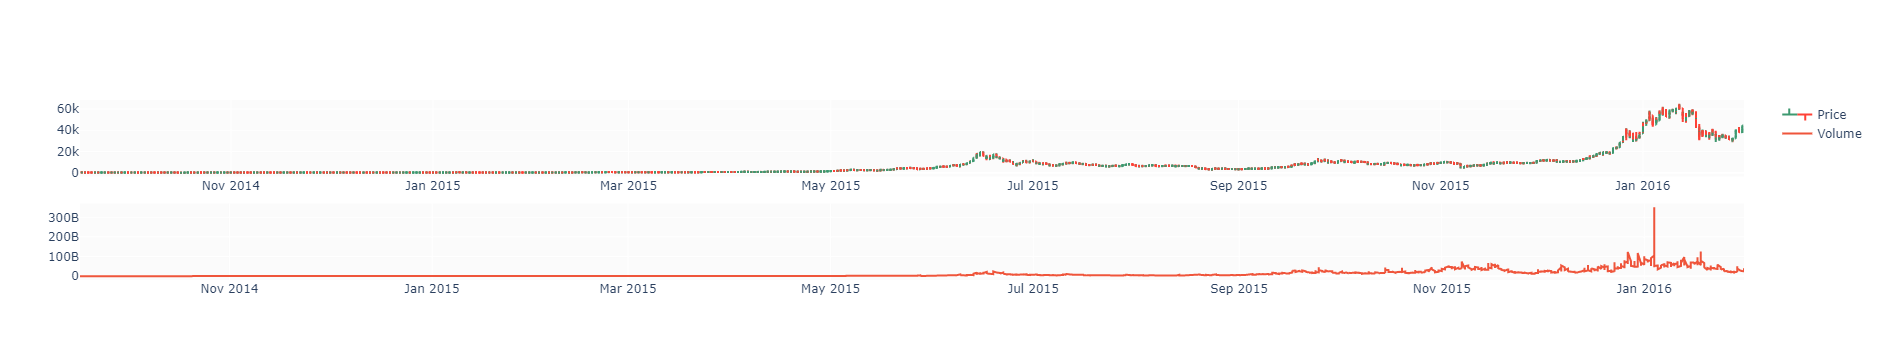

In [61]:
#Exemplo do que estamos lidando: Ativo 1:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df_ativos.index,
                      open=df_ativos[df_ativos['Ativo']=='BTC-USD'].Open,
                      high=df_ativos[df_ativos['Ativo']=='BTC-USD'].High,
                      low=df_ativos[df_ativos['Ativo']=='BTC-USD'].Low,
                      close=df_ativos[df_ativos['Ativo']=='BTC-USD'].Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_ativos.index, y=df_ativos[df_ativos['Ativo']=='BTC-USD'].Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [62]:
df_ativos.groupby(['Ativo']).mean() #Médias de preço de fechamento ['Close']:

Open         High          Low        Close    Adj Close
Ativo                                                                    
ADA-USD      0.278915     0.293999     0.262860     0.279941     0.279941
BCH-USD    536.680961   565.502001   506.992262   536.509332   536.509332
BNB-USD     57.738749    60.621274    54.749031    57.978169    57.978169
BTC-USD   8324.405151  8564.313468  8062.012643  8340.905462  8340.905462
DOGE-USD     0.017501     0.019039     0.016020     0.017605     0.017605
DOT1-USD    18.692737    19.743638    17.539610    18.745647    18.745647
ETH-USD    409.732767   426.153450   391.709831   411.107643   411.107643
HEX-USD      0.022498     0.024336     0.020678     0.022778     0.022778
ICP1-USD    65.638750    71.784184    58.928882    64.415411    64.415411
LINK-USD     6.564180     6.913066     6.182534     6.580892     6.580892
LTC-USD     58.289507    60.726013    55.600899    58.332011    58.332011
SOL1-USD    12.267452    13.145491    11.443901    12.351970    12.351970
UNI3-USD    22.300695    23.531739    20.899827    22.287437    22.287437
USDT-USD     1.000745     1.006836     0.995782     1.000783     1.000783
XRP-USD      0.276120     0.290179     0.261531     0.276456     0.276456

In [63]:
df_ativos.groupby(['Ativo']).count() # -> Nem todos os ativos apresentam cotação para todo o período. Porém há dados que cobrem razoável parte do espectro temporal para cada ativo. Não obstante, alguns ativos mais recentes, como o ICP1, não poderão ser analisados pelo curto prazo de dados.

Open  High   Low  Close  Adj Close  Volume
Ativo                                               
ADA-USD   1403  1403  1403   1403       1403    1403
BCH-USD   1473  1473  1473   1473       1473    1473
BNB-USD   1471  1471  1471   1471       1471    1471
BTC-USD   2513  2513  2513   2513       2513    2513
DOGE-USD  2513  2513  2513   2513       2513    2513
DOT1-USD   330   330   330    330        330     330
ETH-USD   2189  2189  2189   2189       2189    2189
HEX-USD    416   416   416    416        416     416
ICP1-USD    81    81    81     81         81      81
LINK-USD  1414  1414  1414   1414       1414    1414
LTC-USD   2513  2513  2513   2513       2513    2513
SOL1-USD   457   457   457    457        457     457
UNI3-USD   160   160   160    160        160     160
USDT-USD  2340  2340  2340   2340       2340    2340
XRP-USD   2513  2513  2513   2513       2513    2513

In [64]:
#path = r"C:\Users\Alexandre\OneDrive\Documentos\1. PRO\Data Science\Projeto Integrador\Apoio\Abner"
#df_ativos.to_csv(path_or_buf = path+"df_ativos.csv" )

## O paper traz uma série de dados de entrada, que vamos preparar na sequência. São eles:

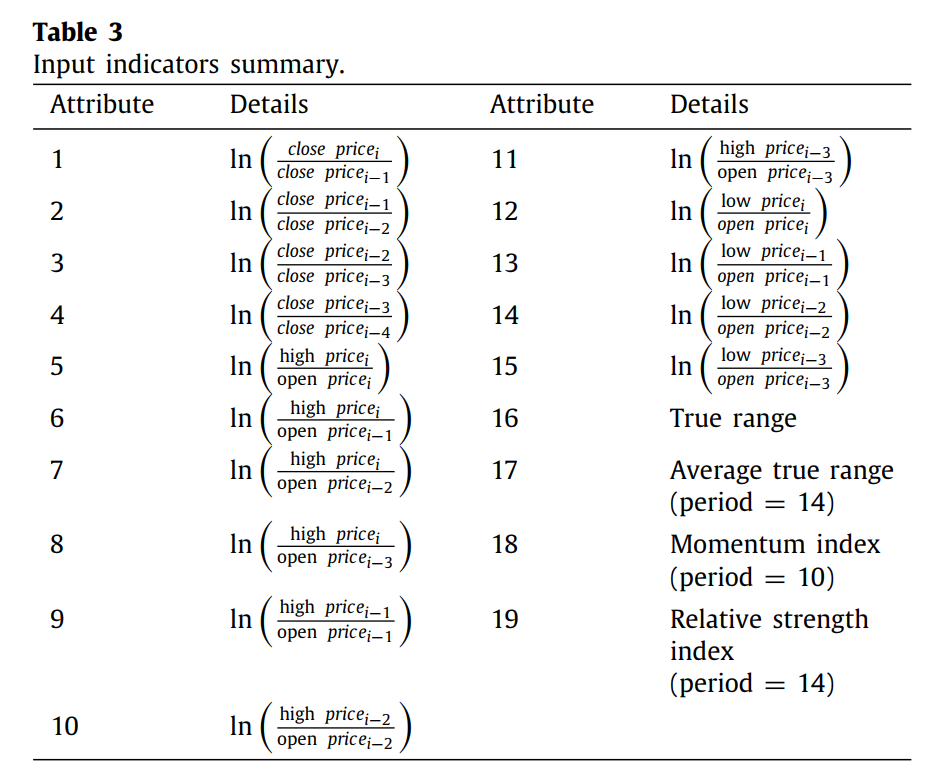

Como se pode observar, são 15 variáveis que envolvem relações temporais entre preços (open, close, high, low), além de 4 outras features muito utilizadas (True Range, Average True Range | 14d, Momentum Index | 10d, Relative Strength Index | 14d).

Na sequência, vamos criar todas essas varíaveis com base nos dados já levantados. Siglas:

* O - Open Price para um dia *"i"* específico
* C - Close Price para um dia *"i"* específico
* H - Highest Price para um dia *"i"* específico
* L - Lowest Price para um dia *"i"* específico



In [65]:
#Criando as features de entrada no DataFrame:

df_ativos['1: ln(C/C-1)'] = pd.Series(dtype=float)
df_ativos['2: ln(C-1/C-2)'] = pd.Series(dtype=float)
df_ativos['3: ln(C-2/C-3)'] = pd.Series(dtype=float)
df_ativos['4: ln(C-3/C-4)'] = pd.Series(dtype=float)
df_ativos['5: ln(H/O)'] = pd.Series(dtype=float)
df_ativos['6: ln(H/O-1)'] = pd.Series(dtype=float)
df_ativos['7: ln(H/O-2)'] = pd.Series(dtype=float)
df_ativos['8: ln(H/O-3)'] = pd.Series(dtype=float)
df_ativos['9: ln(H-1/O-1)'] = pd.Series(dtype=float)
df_ativos['10: ln(H-2/O-2)'] = pd.Series(dtype=float)
df_ativos['11: ln(H-3/O-3)'] = pd.Series(dtype=float)
df_ativos['12: ln(L/O)'] = pd.Series(dtype=float)
df_ativos['13: ln(L-1/O-1)'] = pd.Series(dtype=float)
df_ativos['14: ln(L-2/O-2)'] = pd.Series(dtype=float)
df_ativos['15: ln(L-3/O-3)'] = pd.Series(dtype=float)
df_ativos['16: True Range'] = pd.Series(dtype=float)
df_ativos['17: ATR 14d'] = pd.Series(dtype=float)
df_ativos['18: MI 10d'] = pd.Series(dtype=float)
df_ativos['19: RSI 14d'] = pd.Series(dtype=float)

In [66]:
#Calculando as variáveis com logaritmos naturais "lagged":

for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'1: ln(C/C-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'] / df_ativos.loc[df_ativos['Ativo'] == ativo,'Close'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'2: ln(C-1/C-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'3: ln(C-2/C-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'4: ln(C-3/C-4)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(4))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'5: ln(H/O)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'])
    df_ativos.loc[df_ativos['Ativo'] == ativo,'6: ln(H/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'7: ln(H/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'8: ln(H/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'9: ln(H-1/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'10: ln(H-2/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'11: ln(H-3/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'12: ln(L/O)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'])
    df_ativos.loc[df_ativos['Ativo'] == ativo,'13: ln(L-1/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'14: ln(L-2/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'15: ln(L-3/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))

Variáveis True Range e Average True Range (Explicadas aqui: https://www.investopedia.com/terms/a/atr.asp#:~:text=The%20true%20range%20indicator%20is,days%2C%20of%20the%20true%20ranges.):

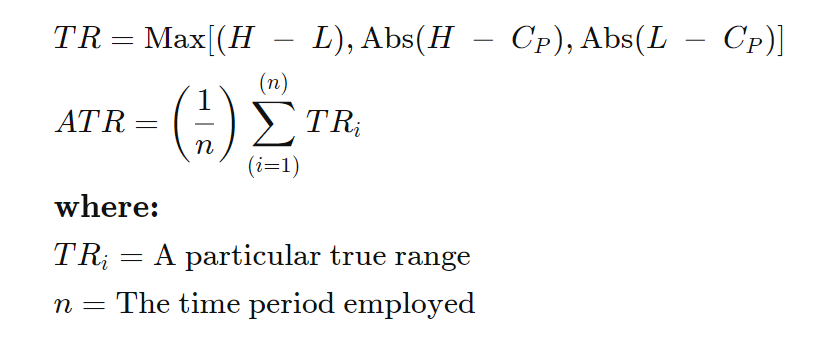



In [67]:
#Calculando as variáveis True Range e Average True Range | 14d:

for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'16: True Range'] = np.nanmax([np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'High'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Low']), 
                                                                            np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'High'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(1)), 
                                                                            np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'Low'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(1))], axis=0)
    
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'17: ATR 14d'] = df_ativos.loc[df_ativos['Ativo'] == ativo,'16: True Range'].rolling(window=14).mean()
    
    



In [68]:
#Calculando a variável MSI | 10d (corresponde à diferença de preços entre o dia atual e o décimo dia anterior. Detalhes: https://help.eaglesmarkets.com/hc/en-us/articles/900002105843-What-are-the-MTM-indicators-Detailed-explanation-of-MTM-index):

for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'18: MI 10d'] = df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(10)


In [69]:
#Função para calcular RSI: [Créditos para https://www.kaggle.com/mtszkw/xgboost-for-stock-trend-prices-prediction, levemente modificado para comportar diversos ativos]

def relative_strength_idx(df, ativo, n=14):
    close = df[df['Ativo']==ativo]['Close']
    delta = close.diff()
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100 - (100 / (1 + rs))
    return rsi

for ativo in ativos:

    df_ativos.loc[df_ativos['Ativo'] == ativo,'19: RSI 14d'] = relative_strength_idx(df_ativos,ativo)
    

In [70]:
df_ativos

Open        High         Low       Close   Adj Close  \
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-17    5.085890    5.170770    4.965950    5.058550    5.058550   
2014-09-17    0.005123    0.005803    0.005123    0.005399    0.005399   
2014-09-17    0.000293    0.000299    0.000260    0.000268    0.000268   
2014-09-18    5.065430    5.065430    4.579960    4.685230    4.685230   
...                ...         ...         ...         ...         ...   
2021-08-07    0.204846    0.261990    0.203772    0.260341    0.260341   
2021-08-07   26.168184   28.996151   25.823141   28.185484   28.185484   
2021-08-07    0.134462    0.138729    0.121389    0.127658    0.127658   
2021-08-07   20.421259   21.682161   20.089033   20.967094   20.967094   
2021-08-07   48.248028   65.941826   47.967983   61.842606   61.842606   

                Volume     Ativo  1: ln(C/C-1)  2: ln(C-1/C-2)  \
2014-09-17    21056800   BTC-USD           NaN             NaN   
2014-09-17     3071840   LTC-USD           NaN             NaN   
2014-09-17     1281960   XRP-USD           NaN             NaN   
2014-09-17     1463600  DOGE-USD           NaN             NaN   
2014-09-18     4569260   LTC-USD     -0.076665             NaN   
...                ...       ...           ...             ...   
2021-08-07  6343062404  DOGE-USD      0.240505        0.018311   
2021-08-07   657129565  UNI3-USD      0.074540        0.027938   
2021-08-07    33634523   HEX-USD     -0.052685       -0.074038   
2021-08-07  1715197695  DOT1-USD      0.027386        0.064186   
2021-08-07  1437084818  ICP1-USD      0.248453        0.138619   

            3: ln(C-2/C-3)  ...  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2014-09-17             NaN  ...              NaN              NaN   
2014-09-17             NaN  ...              NaN              NaN   
2014-09-17             NaN  ...              NaN              NaN   
2014-09-17             NaN  ...              NaN              NaN   
2014-09-18             NaN  ...              NaN              NaN   
...                    ...  ...              ...              ...   
2021-08-07       -0.002564  ...         0.004643         0.034042   
2021-08-07        0.078214  ...         0.080355         0.105874   
2021-08-07       -0.007323  ...         0.063976         0.122887   
2021-08-07       -0.001604  ...         0.015253         0.114065   
2021-08-07        0.065957  ...         0.082500         0.047373   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2014-09-17    -0.029278              NaN              NaN              NaN   
2014-09-17    -0.023865              NaN              NaN              NaN   
2014-09-17     0.000000              NaN              NaN              NaN   
2014-09-17    -0.119491              NaN              NaN              NaN   
2014-09-18    -0.100749        -0.023865              NaN              NaN   
...                 ...              ...              ...              ...   
2021-08-07    -0.005257        -0.011728        -0.034779        -0.009530   
2021-08-07    -0.013273        -0.035428        -0.061063        -0.024530   
2021-08-07    -0.102281        -0.085861        -0.007015        -0.017599   
2021-08-07    -0.016402        -0.030597        -0.067394        -0.016669   
2021-08-07    -0.005821        -0.038305        -0.028269        -0.018444   

            16: True Range  17: ATR 14d  18: MI 10d  19: RSI 14d  
2014-09-17       15.752014          NaN         NaN          NaN  
2014-09-17        0.204820          NaN         NaN          NaN  
2014-09-17        0.000680          NaN         NaN          NaN  
2014-09-17        0.000039          NaN         NaN          NaN  
2014-09-18        0.485470          NaN         NaN          NaN  
...                    ...          ...         ...          ...  
2021-08-07        0.058218     0.015893    0.054949    84.131634  
2021-08-07        3.173010     1.8

In [71]:
df_ativos_sna = df_ativos.dropna() #Muitas métricas precisam de mais dias de medição, de forma que os primeiros são nulos. Ao final, partimos do dia 20/11/2009 para a análise. Lembrando que aqui dropamos as ocorrências intrinsecamente ligadas a cada ativo, de forma que um ativo não atrapalha o outro.
df_ativos_sna

Open        High         Low       Close   Adj Close  \
2014-10-01    4.470960    4.503740    4.384860    4.428560    4.428560   
2014-10-01    0.004645    0.004772    0.004644    0.004752    0.004752   
2014-10-01    0.000400    0.000406    0.000371    0.000371    0.000371   
2014-10-01  387.427002  391.378998  380.779999  383.614990  383.614990   
2014-10-02    0.004755    0.004876    0.004753    0.004874    0.004874   
...                ...         ...         ...         ...         ...   
2021-08-07    0.204846    0.261990    0.203772    0.260341    0.260341   
2021-08-07   26.168184   28.996151   25.823141   28.185484   28.185484   
2021-08-07    0.134462    0.138729    0.121389    0.127658    0.127658   
2021-08-07   20.421259   21.682161   20.089033   20.967094   20.967094   
2021-08-07   48.248028   65.941826   47.967983   61.842606   61.842606   

                Volume     Ativo  1: ln(C/C-1)  2: ln(C-1/C-2)  \
2014-10-01     1172180   LTC-USD     -0.010372        0.052283   
2014-10-01       64998   XRP-USD      0.022989       -0.013050   
2014-10-01     1031360  DOGE-USD     -0.072759        0.007547   
2014-10-01    26229400   BTC-USD     -0.008641        0.030109   
2014-10-02      209158   XRP-USD      0.025349        0.022989   
...                ...       ...           ...             ...   
2021-08-07  6343062404  DOGE-USD      0.240505        0.018311   
2021-08-07   657129565  UNI3-USD      0.074540        0.027938   
2021-08-07    33634523   HEX-USD     -0.052685       -0.074038   
2021-08-07  1715197695  DOT1-USD      0.027386        0.064186   
2021-08-07  1437084818  ICP1-USD      0.248453        0.138619   

            3: ln(C-2/C-3)  ...  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2014-10-01        0.003198  ...         0.021621         0.007428   
2014-10-01       -0.115679  ...         0.030410         0.127323   
2014-10-01        0.010152  ...         0.017611         0.096277   
2014-10-01       -0.004555  ...         0.021737         0.003863   
2014-10-02       -0.013050  ...         0.000425         0.030410   
...                    ...  ...              ...              ...   
2021-08-07       -0.002564  ...         0.004643         0.034042   
2021-08-07        0.078214  ...         0.080355         0.105874   
2021-08-07       -0.007323  ...         0.063976         0.122887   
2021-08-07       -0.001604  ...         0.015253         0.114065   
2021-08-07        0.065957  ...         0.082500         0.047373   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2014-10-01    -0.019445        -0.006195        -0.009372        -0.051438   
2014-10-01    -0.000215        -0.014990        -0.125150        -0.011971   
2014-10-01    -0.075262        -0.028099        -0.041457         0.000000   
2014-10-01    -0.017306        -0.007058        -0.012515        -0.064998   
2014-10-02    -0.000421        -0.000215        -0.014990        -0.125150   
...                 ...              ...              ...              ...   
2021-08-07    -0.005257        -0.011728        -0.034779        -0.009530   
2021-08-07    -0.013273        -0.035428        -0.061063        -0.024530   
2021-08-07    -0.102281        -0.085861        -0.007015        -0.017599   
2021-08-07    -0.016402        -0.030597        -0.067394        -0.016669   
2021-08-07    -0.005821        -0.038305        -0.028269        -0.018444   

            16: True Range  17: ATR 14d  18: MI 10d  19: RSI 14d  
2014-10-01        0.118880     0.276422    0.182640    35.151758  
2014-10-01        0.000128     0.000272    0.000182    37.495167  
2014-10-01        0.000035     0.000042    0.000083    64.265928  
2014-10-01       10.598999    22.595568  -15.206024    31.461697  
2014-10-02        0.000124     0.000250    0.000217    44.662570  
...                    ...          ...         ...          ...  
2021-08-07        0.058218     0.015893    0.054949    84.131634  
2021-08-07        3.173010     1.8

In [72]:
#Dúvida que não quer calar: Usar tudo pra fazer um modelo só (passando OneHotEncoder na feature 'Ativo' e deixando os preços dos ativos se autoinfluenciarem) ou fazer um modelo pra cada ativo?!

In [73]:
#Um modelo pra cada ativo parece fazer mais sentido... 
#Acho que o melhor caminho seria por um dicionário de DFs, uma entrada pra cada ativo.
#Separando os dataframes para cada Ativo em um dicionário, para  e gerar as features de interesse:

dict_ativos = {}

for ativo in ativos:
    dict_ativos[ativo] = df_ativos_sna[df_ativos_sna['Ativo']==ativo]
    

In [74]:
dict_ativos

{'BTC-USD':                     Open          High           Low         Close  \
 2014-10-01    387.427002    391.378998    380.779999    383.614990   
 2014-10-02    383.988007    385.497009    372.946014    375.071991   
 2014-10-03    375.181000    377.695007    357.859009    359.511993   
 2014-10-04    359.891998    364.487000    325.885986    328.865997   
 2014-10-05    328.915985    341.800995    289.295990    320.510010   
 ...                  ...           ...           ...           ...   
 2021-08-03  39178.402344  39750.031250  37782.050781  38152.980469   
 2021-08-04  38213.332031  39952.296875  37589.164062  39747.503906   
 2021-08-05  39744.515625  41341.933594  37458.003906  40869.554688   
 2021-08-06  40865.867188  43271.660156  39932.179688  42816.500000   
 2021-08-07  42832.796875  44689.859375  42618.566406  44555.800781   
 
                Adj Close       Volume    Ativo  1: ln(C/C-1)  2: ln(C-1/C-2)  \
 2014-10-01    383.614990     26229400  BTC-USD     -0

In [75]:
#Fazendo um split do dataset em 80% treino, 20% teste e armazenando cada um em dicionário específico, já retirando as variáveis não desejadas: 

test_size  = 0.20

dict_train = {}
dict_test = {}

dict_X_train = {}
dict_X_test = {}

dict_y_train = {}
dict_y_test = {}


lista_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume',	'Ativo']

for ativo, df in dict_ativos.items():

    test_split_idx  = int(df.shape[0] * (1-test_size))

#Como a ideia é prever o preço do dia seguinte, vamos dar um shift na coluna 'Close'. 
#Teremos todas as features relacionadas ao mesmo dia, mas a variável de saída será o preço do dia seguinte.
  
    
    df['Close'] = df.loc[:,'Close'].shift(-1) #Gera um NA, então vamos ter que dropar novamente...
    df.dropna(inplace=True)
    
    df_train  = df.iloc[:test_split_idx].copy()
    df_test   = df.iloc[test_split_idx+1:].copy()
    
    X_train = df_train.drop(columns = lista_drop).drop(columns='Close')
    X_test = df_test.drop(columns = lista_drop).drop(columns='Close')
    
    y_train = df_train['Close']
    y_test = df_test['Close']

    dict_train[ativo] = df_train.drop(columns = lista_drop)
    dict_test[ativo] = df_test.drop(columns = lista_drop)
    
    dict_X_train[ativo] = X_train
    dict_X_test[ativo] = X_test
    
    dict_y_train[ativo] = y_train
    dict_y_test[ativo] = y_test

<ipython-input-75-d1b77a5251b1>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-75-d1b77a5251b1>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-75-d1b77a5251b1>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-75-d1b77a5251b1>:26: SettingWithCopyWarning:


A value is trying

In [76]:
#Acessando, por exemplo, o df_train do primeiro ativo, o BTC:
list(dict_train.values())[0]

Close  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  \
2014-10-01   375.071991     -0.008641        0.030109       -0.004555   
2014-10-02   359.511993     -0.022521       -0.008641        0.030109   
2014-10-03   328.865997     -0.042370       -0.022521       -0.008641   
2014-10-04   320.510010     -0.089097       -0.042370       -0.022521   
2014-10-05   330.079010     -0.025737       -0.089097       -0.042370   
...                 ...           ...             ...             ...   
2020-03-17  5238.438477      0.041246       -0.072645        0.036246   
2020-03-18  6191.192871      0.002448        0.041246       -0.072645   
2020-03-19  6198.778320      0.167104        0.002448        0.041246   
2020-03-20  6185.066406      0.001224        0.167104        0.002448   
2020-03-21  5830.254883     -0.002214        0.001224        0.167104   

            4: ln(C-3/C-4)  5: ln(H/O)  6: ln(H/O-1)  7: ln(H/O-2)  \
2014-10-01       -0.057539    0.010149      0.039853      0.037622   
2014-10-02       -0.004555    0.003922     -0.004994      0.024710   
2014-10-03        0.030109    0.006678     -0.016524     -0.025440   
2014-10-04       -0.008641    0.012687     -0.028918     -0.052120   
2014-10-05       -0.022521    0.038426     -0.051575     -0.093180   
...                    ...         ...           ...           ...   
2020-03-17       -0.067536    0.071126     -0.002581      0.032215   
2020-03-18        0.036246    0.019836      0.063742     -0.009965   
2020-03-19       -0.072645    0.187904      0.191399      0.235305   
2020-03-20        0.041246    0.100208      0.266056      0.269551   
2020-03-21        0.002448    0.027275      0.029674      0.195521   

            8: ln(H/O-3)  9: ln(H-1/O-1)  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2014-10-01     -0.020465        0.038826         0.021737         0.003863   
2014-10-02      0.022479        0.010149         0.038826         0.021737   
2014-10-03      0.004264        0.003922         0.010149         0.038826   
2014-10-04     -0.061037        0.006678         0.003922         0.010149   
2014-10-05     -0.116383        0.012687         0.006678         0.003922   
...                  ...             ...              ...              ...   
2020-03-17     -0.036868        0.000000         0.115292         0.009314   
2020-03-18      0.024831        0.071126         0.000000         0.115292   
2020-03-19      0.161599        0.019836         0.071126         0.000000   
2020-03-20      0.313457        0.187904         0.019836         0.071126   
2020-03-21      0.199017        0.100208         0.187904         0.019836   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2014-10-01    -0.017306        -0.007058        -0.012515        -0.064998   
2014-10-02    -0.029178        -0.017306        -0.007058        -0.012515   
2014-10-03    -0.047269        -0.029178        -0.017306        -0.007058   
2014-10-04    -0.099256        -0.047269        -0.029178        -0.017306   
2014-10-05    -0.128352        -0.099256        -0.047269        -0.029178   
...                 ...              ...              ...              ...   
2020-03-17    -0.004140        -0.162975        -0.006130        -0.083803   
2020-03-18    -0.030649        -0.004140        -0.162975        -0.006130   
2020-03-19    -0.001612        -0.030649        -0.004140        -0.162975   
2020-03-20    -0.054066        -0.001612        -0.030649        -0.004140   
2020-03-21    -0.045100        -0.054066        -0.001612        -0.030649   

            16: True Range  17: ATR 14d   18: MI 10d  19: RSI 14d  
2014-10-01       10.598999    22.595568   -15.206024    31.461697  
2014-10-02       12.550995    20.332781   -27.080017    35.852649  
2014-10-03       19.835999    18.656568   -76.278992    39.000831  
2014-10-04       38.601013    19.027141   -94.338989    27.381697  
2014-10-05       52.505005    21.402856   -91.063995    27.651597  
...               

In [77]:
list(dict_train.values())[0]

Close  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  \
2014-10-01   375.071991     -0.008641        0.030109       -0.004555   
2014-10-02   359.511993     -0.022521       -0.008641        0.030109   
2014-10-03   328.865997     -0.042370       -0.022521       -0.008641   
2014-10-04   320.510010     -0.089097       -0.042370       -0.022521   
2014-10-05   330.079010     -0.025737       -0.089097       -0.042370   
...                 ...           ...             ...             ...   
2020-03-17  5238.438477      0.041246       -0.072645        0.036246   
2020-03-18  6191.192871      0.002448        0.041246       -0.072645   
2020-03-19  6198.778320      0.167104        0.002448        0.041246   
2020-03-20  6185.066406      0.001224        0.167104        0.002448   
2020-03-21  5830.254883     -0.002214        0.001224        0.167104   

            4: ln(C-3/C-4)  5: ln(H/O)  6: ln(H/O-1)  7: ln(H/O-2)  \
2014-10-01       -0.057539    0.010149      0.039853      0.037622   
2014-10-02       -0.004555    0.003922     -0.004994      0.024710   
2014-10-03        0.030109    0.006678     -0.016524     -0.025440   
2014-10-04       -0.008641    0.012687     -0.028918     -0.052120   
2014-10-05       -0.022521    0.038426     -0.051575     -0.093180   
...                    ...         ...           ...           ...   
2020-03-17       -0.067536    0.071126     -0.002581      0.032215   
2020-03-18        0.036246    0.019836      0.063742     -0.009965   
2020-03-19       -0.072645    0.187904      0.191399      0.235305   
2020-03-20        0.041246    0.100208      0.266056      0.269551   
2020-03-21        0.002448    0.027275      0.029674      0.195521   

            8: ln(H/O-3)  9: ln(H-1/O-1)  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2014-10-01     -0.020465        0.038826         0.021737         0.003863   
2014-10-02      0.022479        0.010149         0.038826         0.021737   
2014-10-03      0.004264        0.003922         0.010149         0.038826   
2014-10-04     -0.061037        0.006678         0.003922         0.010149   
2014-10-05     -0.116383        0.012687         0.006678         0.003922   
...                  ...             ...              ...              ...   
2020-03-17     -0.036868        0.000000         0.115292         0.009314   
2020-03-18      0.024831        0.071126         0.000000         0.115292   
2020-03-19      0.161599        0.019836         0.071126         0.000000   
2020-03-20      0.313457        0.187904         0.019836         0.071126   
2020-03-21      0.199017        0.100208         0.187904         0.019836   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2014-10-01    -0.017306        -0.007058        -0.012515        -0.064998   
2014-10-02    -0.029178        -0.017306        -0.007058        -0.012515   
2014-10-03    -0.047269        -0.029178        -0.017306        -0.007058   
2014-10-04    -0.099256        -0.047269        -0.029178        -0.017306   
2014-10-05    -0.128352        -0.099256        -0.047269        -0.029178   
...                 ...              ...              ...              ...   
2020-03-17    -0.004140        -0.162975        -0.006130        -0.083803   
2020-03-18    -0.030649        -0.004140        -0.162975        -0.006130   
2020-03-19    -0.001612        -0.030649        -0.004140        -0.162975   
2020-03-20    -0.054066        -0.001612        -0.030649        -0.004140   
2020-03-21    -0.045100        -0.054066        -0.001612        -0.030649   

            16: True Range  17: ATR 14d   18: MI 10d  19: RSI 14d  
2014-10-01       10.598999    22.595568   -15.206024    31.461697  
2014-10-02       12.550995    20.332781   -27.080017    35.852649  
2014-10-03       19.835999    18.656568   -76.278992    39.000831  
2014-10-04       38.601013    19.027141   -94.338989    27.381697  
2014-10-05       52.505005    21.402856   -91.063995    27.651597  
...               

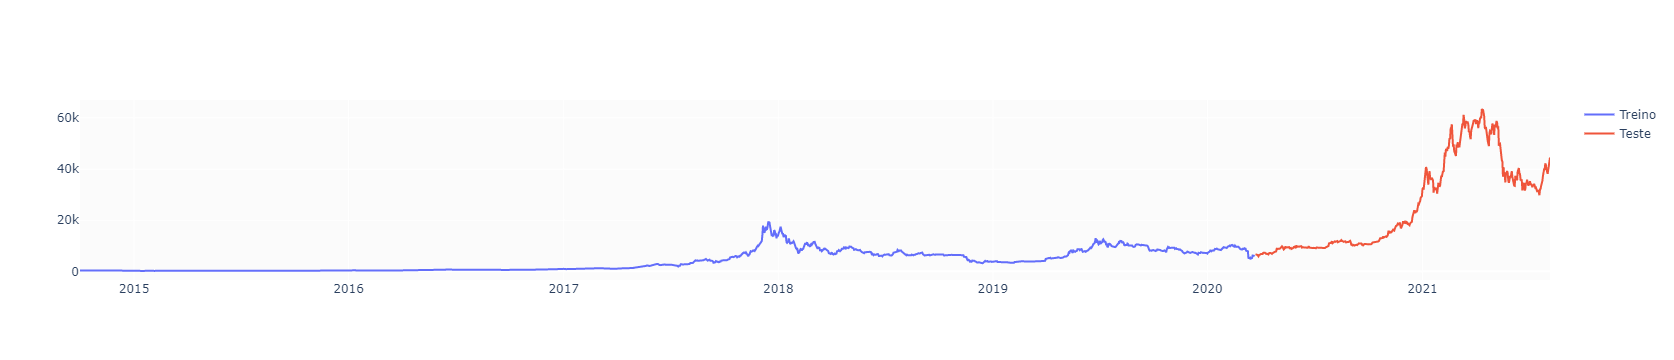

In [78]:
#Vamos ver a cara dessa bagaça e como ficaram temporalmente treino, validação e teste...
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(dict_train.values())[0].index, y=list(dict_train.values())[0].Close, name='Treino'))
fig.add_trace(go.Scatter(x=list(dict_test.values())[0].index,  y=list(dict_test.values())[0].Close,  name='Teste'))
fig.show()

In [79]:
#Ok, parece que temos tudo para começar a modelagem. Vamos ao que interessa...

In [80]:
#!pip install xgboost

In [81]:
#Vamos checar as variáveis de entrada para o primeiro ativo
list(dict_X_train.values())[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1999 entries, 2014-10-01 to 2020-03-21
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1: ln(C/C-1)     1999 non-null   float64
 1   2: ln(C-1/C-2)   1999 non-null   float64
 2   3: ln(C-2/C-3)   1999 non-null   float64
 3   4: ln(C-3/C-4)   1999 non-null   float64
 4   5: ln(H/O)       1999 non-null   float64
 5   6: ln(H/O-1)     1999 non-null   float64
 6   7: ln(H/O-2)     1999 non-null   float64
 7   8: ln(H/O-3)     1999 non-null   float64
 8   9: ln(H-1/O-1)   1999 non-null   float64
 9   10: ln(H-2/O-2)  1999 non-null   float64
 10  11: ln(H-3/O-3)  1999 non-null   float64
 11  12: ln(L/O)      1999 non-null   float64
 12  13: ln(L-1/O-1)  1999 non-null   float64
 13  14: ln(L-2/O-2)  1999 non-null   float64
 14  15: ln(L-3/O-3)  1999 non-null   float64
 15  16: True Range   1999 non-null   float64
 16  17: ATR 14d      1999 non-null   float64
 

# Definindo uma função para rodar modelo, mostrar resultados e plotar feature importance, além de armazenar tudo num DF:

In [82]:
cols_params=['learning_rate', 'n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda'] 
cols_results = ['MAPE_train', 'MAPE_test', 'MSE_train', 'MSE_test', 'MAE_train', 'MAE_test', 'RMSE_train', 'RMSE_test']
cols_params.extend(cols_results)
df_model = pd.DataFrame(columns = cols_params)
df_model

Empty DataFrame
Columns: [learning_rate, n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree, reg_alpha, reg_lambda, MAPE_train, MAPE_test, MSE_train, MSE_test, MAE_train, MAE_test, RMSE_train, RMSE_test]
Index: []

In [83]:
# Créditos: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

def model_fit(estimator, dtrain, dtest, features, target, dmodel, cv_folds=10, early_stopping_rounds=50):
    
    xgb_param = estimator.get_xgb_params()
    
    xgtrain = xgb.DMatrix(data = dtrain[features].values, label = dtrain[target].values)
    
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = estimator.get_params()['n_estimators'], nfold = cv_folds,
                      metrics ='rmse', early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
    
    estimator.set_params(n_estimators=cvresult.shape[0])
    
  
        
    
    #Fit the algorithm on the data
    
    estimator.fit(dtrain[features], dtrain[target], eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = estimator.predict(dtrain[features])
    
        
    #Printar resultados no treino:
    print ("\nResultados do modelo no treino")
    #print ("Accuracy : %.4g" % metrics.accuracy_score(df_train['Disbursed'].values, df_train_predictions))
    
    #MAPE = mean_absolute_percentage_error(y_true = list(dict_test.values())[0]['Close'], y_pred = y_pred_test) -> Fazer na mão grande
    MAPE_train = np.mean(np.abs((dtrain[target].values - dtrain_predictions)/dtrain[target].values))
    MSE_train = mean_squared_error(y_true = dtrain[target].values, y_pred = dtrain_predictions, squared = False)
    MAE_train = mean_absolute_error(y_true = dtrain[target].values, y_pred = dtrain_predictions)
    RMSE_train = mean_squared_error(y_true = dtrain[target].values, y_pred = dtrain_predictions, squared = True)
    
    print(f'MAPE = {MAPE_train:.4f}')
    print(f'MSE = {MSE_train:.4f}')
    print(f'MAE = {MAE_train:.4f}')
    print(f'RMSE = {RMSE_train:.4f}')
    
    
    #Prever e printar resultados no teste:
    
    dtest_predictions = estimator.predict(dtest[features])
    
    #MAPE = mean_absolute_percentage_error(y_true = list(dict_test.values())[0]['Close'], y_pred = y_pred_test) -> Fazer na mão grande
    MAPE_test = np.mean(np.abs((dtest[target].values - dtest_predictions)/dtest[target].values))
    MSE_test = mean_squared_error(y_true = dtest[target].values, y_pred = dtest_predictions, squared = False)
    MAE_test = mean_absolute_error(y_true = dtest[target].values, y_pred = dtest_predictions)
    RMSE_test = mean_squared_error(y_true = dtest[target].values, y_pred = dtest_predictions, squared = True)

    print ("\nResultados do modelo no teste")
    print(f'MAPE = {MAPE_test:.4f}')
    print(f'MSE = {MSE_test:.4f}')
    print(f'MAE = {MAE_test:.4f}')
    print(f'RMSE = {RMSE_test:.4f}')
    
   
    
    #Plotar gráfico treino e teste:
    
    print ("\n")
    print ("Time Series de treino e teste:")

    plt.rcParams["figure.figsize"] = (100, 20)
    fig = make_subplots(rows=3, cols=1, )

    fig.add_trace(go.Scatter(x = dtrain.index, y = dtrain[target].values,
                             name='Real - Treino',
                             marker_color='Green'), row=1, col=1)

    fig.add_trace(go.Scatter(x = dtrain.index,
                             y = dtrain_predictions,
                             name='Predição - Treino',
                             marker_color='DarkBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x = dtest.index, y = dtest[target].values,
                             name='Real - Teste',
                             marker_color='Green'), row=3, col=1)

    fig.add_trace(go.Scatter(x = dtest.index,
                             y = dtest_predictions,
                             name='Predição - Teste',
                             marker_color='DarkBlue'), row=3, col=1)

    fig.show()
    
     
    #Plotar feature importance:
    
    print ("\n")
    plt.rcParams["figure.figsize"] = (20, 10)
    plot_importance(estimator, height = 0.5)
    
    #Armazenando os parâmetros e resultados em um DF:
    
    params_results = []
    
    cols_params=['learning_rate', 'n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda'] 
    cols_results = ['MAPE_train', 'MAPE_test', 'MSE_train', 'MSE_test', 'MAE_train', 'MAE_test', 'RMSE_train', 'RMSE_test']
    
    for i in range(len(cols_params)):
        params_results.append(estimator.get_params()[cols_params[i]])
    
    params_results.extend([MAPE_train, MAPE_test, MSE_train, MSE_test, MAE_train, MAE_test, RMSE_train, RMSE_test])
    
    dmodel.loc[len(dmodel)] = params_results
    print ("DataFrame consolidado de parâmetros e resultados tentados até aqui:")
    
    return dmodel
    print ("\n")
    

## Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

[0]	train-rmse:5110.85435+20.65355	test-rmse:5111.43662+188.76702
[1]	train-rmse:4637.62432+21.76432	test-rmse:4643.64185+168.92291
[2]	train-rmse:4208.45889+19.80248	test-rmse:4221.73528+156.37869
[3]	train-rmse:3825.43960+15.35602	test-rmse:3845.41687+144.63634
[4]	train-rmse:3483.37942+20.94693	test-rmse:3513.30667+131.80015
[5]	train-rmse:3175.94568+22.14310	test-rmse:3214.26729+121.39714
[6]	train-rmse:2897.17175+19.58517	test-rmse:2941.61233+117.00956
[7]	train-rmse:2645.80508+17.74200	test-rmse:2696.96345+111.17038
[8]	train-rmse:2420.58120+15.46121	test-rmse:2480.62136+107.18758
[9]	train-rmse:2218.98120+13.81020	test-rmse:2287.29749+100.92820
[10]	train-rmse:2038.47455+13.39196	test-rmse:2114.92760+98.28365
[11]	train-rmse:1876.78954+12.55838	test-rmse:1959.43677+95.90810
[12]	train-rmse:1732.49532+11.23495	test-rmse:1825.32428+92.92880
[13]	train-rmse:1605.55344+9.41801	test-rmse:1707.32626+91.27790
[14]	train-rmse:1490.81404+8.61323	test-rmse:1602.67821+90.53733
[15]	train-r

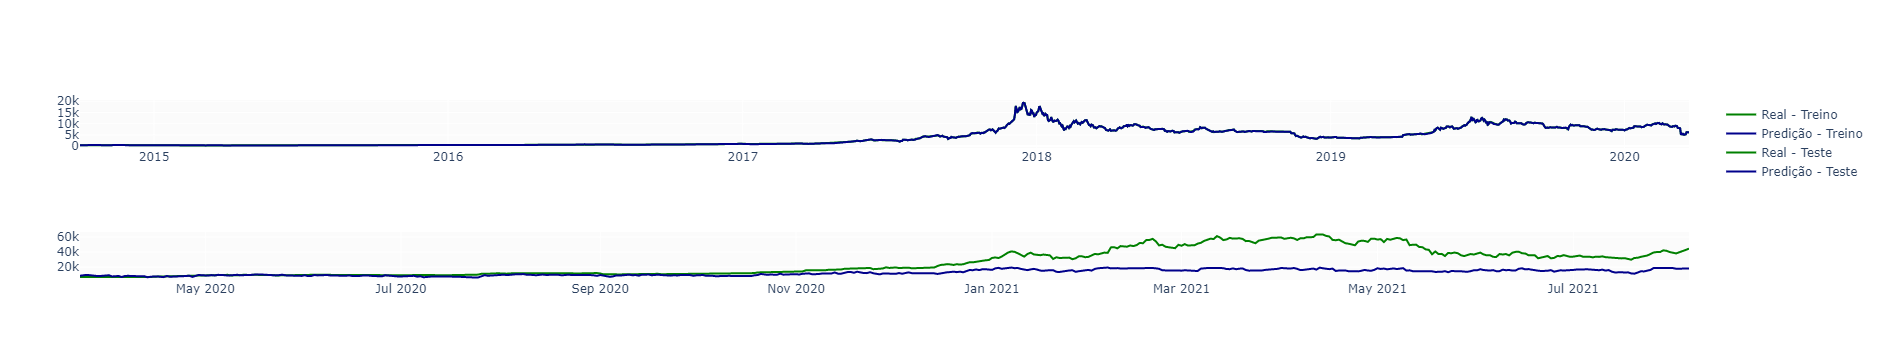



DataFrame consolidado de parâmetros e resultados tentados até aqui:


learning_rate  n_estimators  max_depth  min_child_weight  gamma  subsample  \
0            0.1         803.0        5.0               1.0    0.0        0.8   

   colsample_bytree  reg_alpha  reg_lambda  MAPE_train  MAPE_test  MSE_train  \
0               0.8        0.0         1.0    0.005677   0.382134    6.87414   

       MSE_test  MAE_train      MAE_test  RMSE_train     RMSE_test  
0  19683.201573   5.139906  13778.137542   47.253806  3.874284e+08

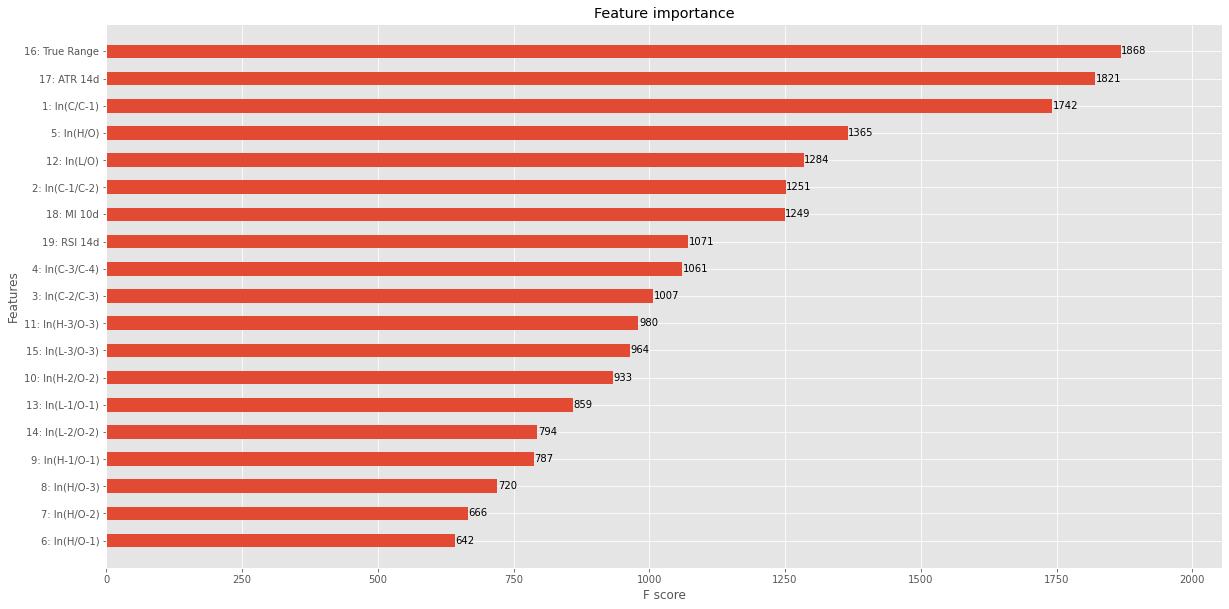

In [84]:
#Vamos setar learning_rate para 0.1 e n_etimators para 1000. A ideia é tunar apenas os parâmetros específicos de árvores, que vão começar como segue:

xgb1 = xgb.XGBRegressor(
         learning_rate =0.1,
         n_estimators=1000,
         max_depth=5,
         min_child_weight=1,
         gamma=0,
         colsample_bytree=0.8,
         subsample = 0.8,
         objective= 'reg:squarederror',
         nthread=6,
         seed=248)

model_fit(estimator = xgb1, dtrain = list(dict_train.values())[0], dtest = list(dict_test.values())[0], features = list(dict_X_train.values())[0].columns, target = 'Close', dmodel = df_model, cv_folds=10, early_stopping_rounds=50)

Como o erro continuou caindo até o 852º estimador, vamos atribuir esse valor a n_estimator. Percebemos que há claramente um overfitting quando observamos a série temporal de treino.

## Step 2: Tune max_depth and min_child_weight
We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [88]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,8,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=852, max_depth=5,
                         min_child_weight=1, gamma=0, colsample_bytree=0.8, subsample = 0.8,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test1, n_jobs= -1, cv=5, verbose=2)

gsearch1.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch1.cv_results_['params'], gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished


([{'max_depth': 3, 'min_child_weight': 1},
  {'max_depth': 3, 'min_child_weight': 3},
  {'max_depth': 3, 'min_child_weight': 5},
  {'max_depth': 3, 'min_child_weight': 7},
  {'max_depth': 5, 'min_child_weight': 1},
  {'max_depth': 5, 'min_child_weight': 3},
  {'max_depth': 5, 'min_child_weight': 5},
  {'max_depth': 5, 'min_child_weight': 7},
  {'max_depth': 7, 'min_child_weight': 1},
  {'max_depth': 7, 'min_child_weight': 3},
  {'max_depth': 7, 'min_child_weight': 5},
  {'max_depth': 7, 'min_child_weight': 7},
  {'max_depth': 9, 'min_child_weight': 1},
  {'max_depth': 9, 'min_child_weight': 3},
  {'max_depth': 9, 'min_child_weight': 5},
  {'max_depth': 9, 'min_child_weight': 7}],
 {'max_depth': 7, 'min_child_weight': 5},
 -1.611260571821188)

Encontramos os melhores valores. Para aprofundar, vamos aumentar a granularidade do teste variando os best_params em +1 e -1.

In [89]:
param_test2 = {
 'max_depth':[6, 7, 8],
 'min_child_weight':[4, 5, 6]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=1000, max_depth=7,
                         min_child_weight=5, gamma=0, colsample_bytree=0.8, subsample = 0.8,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test2, n_jobs= -1, cv=5, verbose=2)

gsearch2.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch2.cv_results_['params'], gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished


([{'max_depth': 6, 'min_child_weight': 4},
  {'max_depth': 6, 'min_child_weight': 5},
  {'max_depth': 6, 'min_child_weight': 6},
  {'max_depth': 7, 'min_child_weight': 4},
  {'max_depth': 7, 'min_child_weight': 5},
  {'max_depth': 7, 'min_child_weight': 6},
  {'max_depth': 8, 'min_child_weight': 4},
  {'max_depth': 8, 'min_child_weight': 5},
  {'max_depth': 8, 'min_child_weight': 6}],
 {'max_depth': 7, 'min_child_weight': 5},
 -1.611260571821188)

Permanecemos com os valores encontrados como os melhores parâmetros.

## Step 3: Tune gamma
Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here. 

In [90]:
param_test3 = {
 'gamma':[i/10 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=1000, max_depth=7,
                         min_child_weight=5, gamma=0, colsample_bytree=0.8, subsample = 0.8,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test3, n_jobs= -1, cv=5, verbose=2)

gsearch3.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch3.cv_results_['params'], gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


([{'gamma': 0.0},
  {'gamma': 0.1},
  {'gamma': 0.2},
  {'gamma': 0.3},
  {'gamma': 0.4},
  {'gamma': 0.5},
  {'gamma': 0.6},
  {'gamma': 0.7},
  {'gamma': 0.8},
  {'gamma': 0.9}],
 {'gamma': 0.6},
 -1.6059314760093577)

gamma = 0.6 se mostrou um bom valor. Agora que fizemos esse passo, é importante voltar a avaliar o n_estimators. Vamos lá:

[0]	train-rmse:5108.35327+20.80529	test-rmse:5108.65674+186.27093
[1]	train-rmse:4628.20635+18.10701	test-rmse:4634.60957+172.20381
[2]	train-rmse:4195.74131+16.47143	test-rmse:4210.52144+160.01598
[3]	train-rmse:3809.60061+21.94404	test-rmse:3830.89922+146.72655
[4]	train-rmse:3461.91184+29.68200	test-rmse:3490.81128+130.07783
[5]	train-rmse:3147.78906+29.07557	test-rmse:3184.05801+116.56760
[6]	train-rmse:2871.80303+48.33954	test-rmse:2918.81401+104.77540
[7]	train-rmse:2613.38164+44.20602	test-rmse:2670.29724+102.20526
[8]	train-rmse:2380.85347+40.84646	test-rmse:2448.86321+97.86469
[9]	train-rmse:2174.49419+36.15577	test-rmse:2255.25415+96.33824
[10]	train-rmse:1987.55140+33.53491	test-rmse:2080.16102+99.31703
[11]	train-rmse:1818.40304+29.67279	test-rmse:1922.51799+97.55052
[12]	train-rmse:1664.39269+27.30211	test-rmse:1783.63013+95.12639
[13]	train-rmse:1526.90723+25.24067	test-rmse:1659.56687+92.17427
[14]	train-rmse:1403.62052+22.61475	test-rmse:1550.46836+89.73631
[15]	train-r

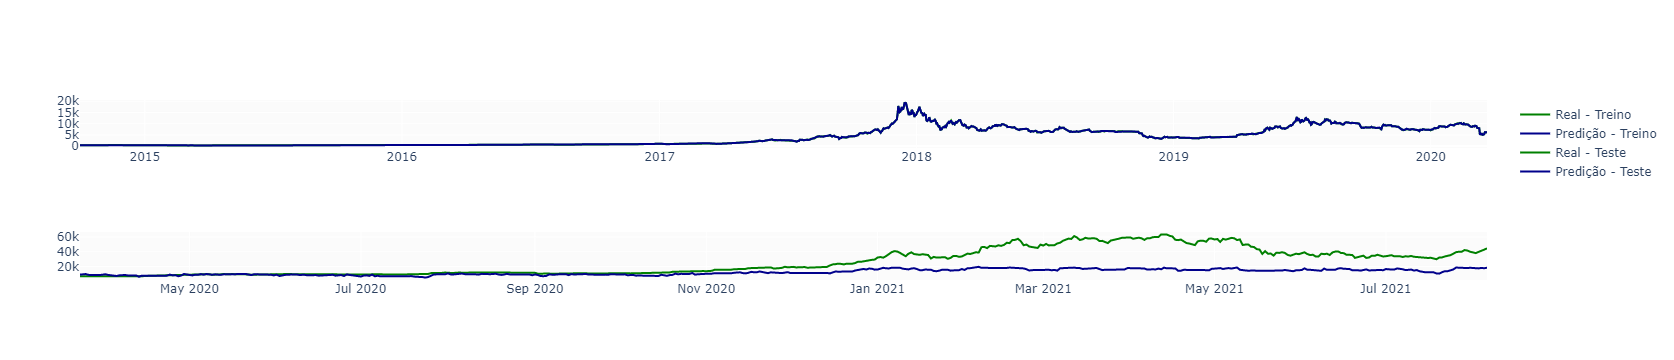



DataFrame consolidado de parâmetros e resultados tentados até aqui:


learning_rate  n_estimators  max_depth  min_child_weight  gamma  subsample  \
0            0.1         803.0        5.0               1.0    0.0        0.8   
1            0.1         401.0        7.0               5.0    0.6        1.0   

   colsample_bytree  reg_alpha  reg_lambda  MAPE_train  MAPE_test  MSE_train  \
0               0.8        0.0         1.0    0.005677   0.382134   6.874140   
1               0.8        0.0         1.0    0.004380   0.393929   7.380973   

       MSE_test  MAE_train      MAE_test  RMSE_train     RMSE_test  
0  19683.201573   5.139906  13778.137542   47.253806  3.874284e+08  
1  19856.448987   4.781554  13989.589264   54.478768  3.942786e+08

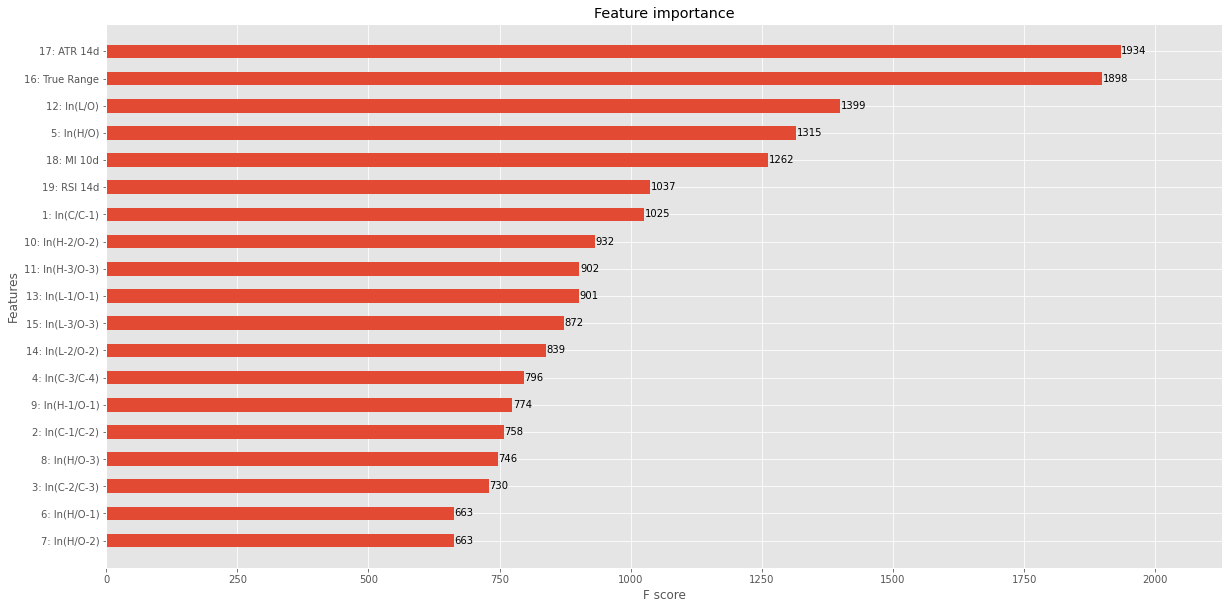

In [91]:
xgb2 = xgb.XGBRegressor(
         learning_rate =0.1,
         n_estimators=2000,
         max_depth=7,
         min_child_weight=5,
         gamma=0.6,
         colsample_bytree=0.8,
         objective= 'reg:squarederror',
         nthread=6,
         seed=248)

model_fit(estimator = xgb2, dtrain = list(dict_train.values())[0], dtest = list(dict_test.values())[0], features = list(dict_X_train.values())[0].columns, target = 'Close', dmodel = df_model, cv_folds=10, early_stopping_rounds=50)

"n_estimators" deve assumir o valor 450, já que o aumento da quantidade de árvores não se justifica pela diminuição no erro.

## Step 4: Tune subsample and colsample_bytree
The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [92]:
param_test4 = {
 'subsample':[i/10 for i in range(6,10)],
 'colsample_bytree':[i/10 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=450, max_depth=7,
                         min_child_weight=5, gamma=0.6, subsample = 0.8, colsample_bytree=0.8,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test4, n_jobs= -1, cv=5, verbose=2)

gsearch4.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch4.cv_results_['params'], gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   48.8s finished


([{'colsample_bytree': 0.6, 'subsample': 0.6},
  {'colsample_bytree': 0.6, 'subsample': 0.7},
  {'colsample_bytree': 0.6, 'subsample': 0.8},
  {'colsample_bytree': 0.6, 'subsample': 0.9},
  {'colsample_bytree': 0.7, 'subsample': 0.6},
  {'colsample_bytree': 0.7, 'subsample': 0.7},
  {'colsample_bytree': 0.7, 'subsample': 0.8},
  {'colsample_bytree': 0.7, 'subsample': 0.9},
  {'colsample_bytree': 0.8, 'subsample': 0.6},
  {'colsample_bytree': 0.8, 'subsample': 0.7},
  {'colsample_bytree': 0.8, 'subsample': 0.8},
  {'colsample_bytree': 0.8, 'subsample': 0.9},
  {'colsample_bytree': 0.9, 'subsample': 0.6},
  {'colsample_bytree': 0.9, 'subsample': 0.7},
  {'colsample_bytree': 0.9, 'subsample': 0.8},
  {'colsample_bytree': 0.9, 'subsample': 0.9}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 -1.6147184898593465)

Agora que encontramos os melhores valores, vamos aumentar a granularidade para 0.05 e observar:

In [93]:
param_test5 = {
 'subsample':[i/100 for i in range(75,90,5)],
 'colsample_bytree':[i/100 for i in range(75,90,5)]
}

gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=450, max_depth=7,
                         min_child_weight=5, gamma=0.6, subsample = 0.7, colsample_bytree=0.9,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test5, n_jobs= -1, cv=5, verbose=2)

gsearch5.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch5.cv_results_['params'], gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   31.9s finished


([{'colsample_bytree': 0.75, 'subsample': 0.75},
  {'colsample_bytree': 0.75, 'subsample': 0.8},
  {'colsample_bytree': 0.75, 'subsample': 0.85},
  {'colsample_bytree': 0.8, 'subsample': 0.75},
  {'colsample_bytree': 0.8, 'subsample': 0.8},
  {'colsample_bytree': 0.8, 'subsample': 0.85},
  {'colsample_bytree': 0.85, 'subsample': 0.75},
  {'colsample_bytree': 0.85, 'subsample': 0.8},
  {'colsample_bytree': 0.85, 'subsample': 0.85}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 -1.6147184898593465)

Valores não se alteraram.

## Step 5: Tuning Regularization Parameters
Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [98]:
param_test6 = {
 'reg_alpha':[0, 1e-4, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=450, max_depth=7,
                         min_child_weight=5, gamma=0.6, subsample = 0.8, colsample_bytree=0.8,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test6, n_jobs= -1, cv=5, verbose=2)

gsearch6.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch6.cv_results_['params'], gsearch6.best_params_, gsearch6.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.5s finished


([{'reg_alpha': 0},
  {'reg_alpha': 0.0001},
  {'reg_alpha': 0.01},
  {'reg_alpha': 0.1},
  {'reg_alpha': 1},
  {'reg_alpha': 100}],
 {'reg_alpha': 0.0001},
 -1.6100324839600586)

Aparentemente, o alpha ideal deve ser pequeno, da ordem de 0.0001. Vamos explorar um pouco mais aumentando a granularidade:

In [99]:
param_test7 = {
 'reg_alpha':[1e-5, 1e-4, 5e-4, 1e-3, 5e-2]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=450, max_depth=7,
                         min_child_weight=5, gamma=0.6, subsample = 0.8, colsample_bytree=0.8,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test7, n_jobs= -1, cv=5, verbose=2)

gsearch7.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch7.cv_results_['params'], gsearch7.best_params_, gsearch7.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   19.0s finished


([{'reg_alpha': 1e-05},
  {'reg_alpha': 0.0001},
  {'reg_alpha': 0.0005},
  {'reg_alpha': 0.001},
  {'reg_alpha': 0.05}],
 {'reg_alpha': 0.0001},
 -1.6100324839600586)

reg_alpha = 0.0001 confirmou ser o melhor valor.
Agora vamos rodar mais uma vez o modelo, dessa vez aumentando o n_estimators para avaliar o número ideal:

[0]	train-rmse:5108.85342+20.65949	test-rmse:5110.95522+188.03813
[1]	train-rmse:4632.49004+20.44699	test-rmse:4641.40566+167.78186
[2]	train-rmse:4200.90034+18.52898	test-rmse:4220.67961+157.10276
[3]	train-rmse:3813.51904+15.03235	test-rmse:3840.20601+147.88150
[4]	train-rmse:3467.89268+19.56150	test-rmse:3503.46987+130.82944
[5]	train-rmse:3156.65708+20.25978	test-rmse:3202.30398+122.24268
[6]	train-rmse:2872.67932+18.64870	test-rmse:2923.41221+115.26932
[7]	train-rmse:2616.19209+16.34936	test-rmse:2675.26680+107.25311
[8]	train-rmse:2385.13040+15.19372	test-rmse:2453.40422+102.97445
[9]	train-rmse:2177.92241+13.95875	test-rmse:2258.42366+98.25272
[10]	train-rmse:1991.53752+12.98663	test-rmse:2084.22618+97.19525
[11]	train-rmse:1822.99963+12.70132	test-rmse:1926.24895+94.77792
[12]	train-rmse:1671.81139+11.62909	test-rmse:1787.08196+92.58889
[13]	train-rmse:1537.09292+9.52870	test-rmse:1667.04866+95.01177
[14]	train-rmse:1414.40629+7.91042	test-rmse:1557.47231+92.12736
[15]	train-rm

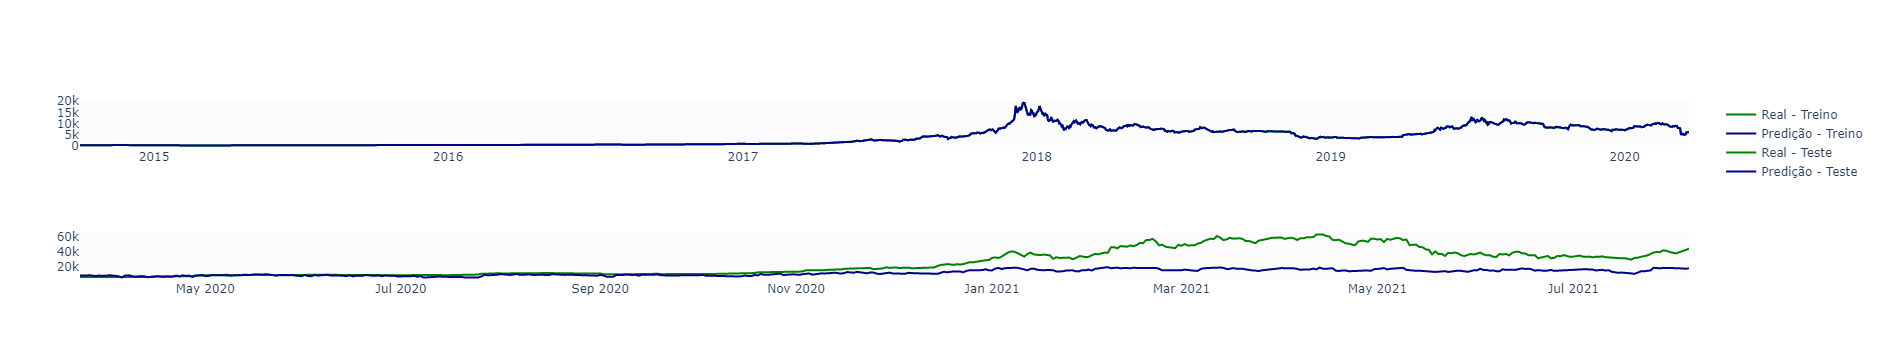



DataFrame consolidado de parâmetros e resultados tentados até aqui:


learning_rate  n_estimators  max_depth  min_child_weight  gamma  subsample  \
0            0.1         803.0        5.0               1.0    0.0        0.8   
1            0.1         401.0        7.0               5.0    0.6        1.0   
2            0.1         728.0        7.0               5.0    0.6        0.8   
3            0.1         728.0        7.0               5.0    0.6        0.8   

   colsample_bytree  reg_alpha  reg_lambda  MAPE_train  MAPE_test  MSE_train  \
0               0.8     0.0000         1.0    0.005677   0.382134   6.874140   
1               0.8     0.0000         1.0    0.004380   0.393929   7.380973   
2               0.8     0.0001         1.0    0.000420   0.384805   0.525531   
3               0.8     0.0001         1.0    0.000420   0.384805   0.525531   

       MSE_test  MAE_train      MAE_test  RMSE_train     RMSE_test  
0  19683.201573   5.139906  13778.137542   47.253806  3.874284e+08  
1  19856.448987   4.781554  13989.589264   54.478768  3.942786e+08  
2  19624.206898   0.364898  13776.432786    0.276182  3.851095e+08  
3  19624.206898   0.364898  13776.432786    0.276182  3.851095e+08

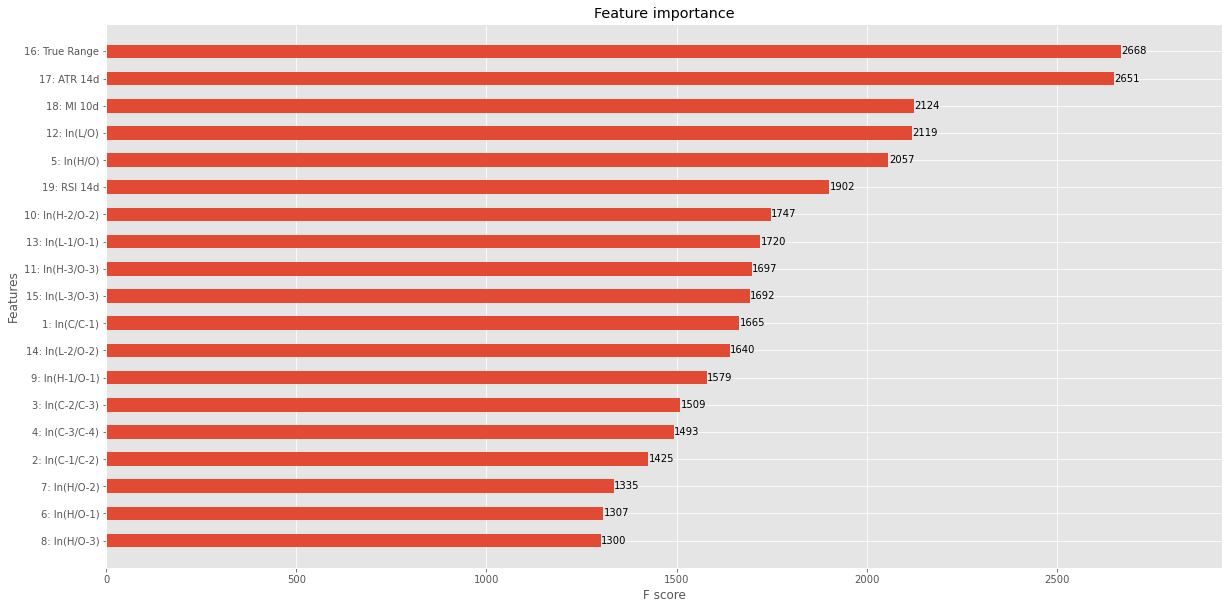

In [100]:
xgb3 = xgb.XGBRegressor(
         learning_rate =0.1,
         n_estimators=5000,
         max_depth=7,
         min_child_weight=5,
         gamma=0.6,
         colsample_bytree=0.8,
         subsample = 0.8,
         reg_alpha = 0.0001,
         objective= 'reg:squarederror',
         nthread=6,
         seed=248)

model_fit(estimator = xgb3, dtrain = list(dict_train.values())[0], dtest = list(dict_test.values())[0], features = list(dict_X_train.values())[0].columns, target = 'Close', dmodel = df_model, cv_folds=10, early_stopping_rounds=50)

Ainda bastante overfitado... n_estimators poderia adotar o valor de 777. Vamos checar o reg_lambda.

### Explorando o reg_lambda:

In [101]:
param_test8 = {
 'reg_lambda':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
gsearch8 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=777, max_depth=7,
                         min_child_weight=5, gamma=0.6, subsample = 0.8, colsample_bytree=0.8, reg_alpha = 0.0001,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test8, n_jobs= -1, cv=5, verbose=2)

gsearch8.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch8.cv_results_['params'], gsearch8.best_params_, gsearch8.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   29.4s finished


([{'reg_lambda': 0},
  {'reg_lambda': 1e-05},
  {'reg_lambda': 0.01},
  {'reg_lambda': 0.1},
  {'reg_lambda': 1},
  {'reg_lambda': 100}],
 {'reg_lambda': 100},
 -1.1309767557460557)

Opa... lambda 100 é o melhor valor até então. Vamos aumentar um pouco mais esse range em torno desse valor, para verificar:

In [103]:
param_test9 = {
 'reg_lambda':[90, 100, 500, 1000, 2000, 2500]
}
gsearch9 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=777, max_depth=7,
                         min_child_weight=5, gamma=0.6, subsample = 0.8, colsample_bytree=0.8, reg_alpha = 0.0001,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test9, n_jobs= -1, cv=5, verbose=2)

gsearch9.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch9.cv_results_['params'], gsearch9.best_params_, gsearch9.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.0s finished


([{'reg_lambda': 90},
  {'reg_lambda': 100},
  {'reg_lambda': 500},
  {'reg_lambda': 1000},
  {'reg_lambda': 2000},
  {'reg_lambda': 2500}],
 {'reg_lambda': 2000},
 -0.8193856299392046)

Ok... reg_lambda assumirá 2000

[0]	train-rmse:5629.72183+22.87435	test-rmse:5625.93228+207.72679
[1]	train-rmse:5616.71138+22.80117	test-rmse:5612.93271+207.47659
[2]	train-rmse:5603.76494+22.73932	test-rmse:5600.01226+207.19263
[3]	train-rmse:5590.89219+22.52117	test-rmse:5587.15591+207.06411
[4]	train-rmse:5578.05903+22.47233	test-rmse:5574.33047+206.78417
[5]	train-rmse:5565.43145+22.38998	test-rmse:5561.70024+206.52681
[6]	train-rmse:5552.67729+22.31162	test-rmse:5548.96294+206.26620
[7]	train-rmse:5539.98877+22.24957	test-rmse:5536.27847+206.00524
[8]	train-rmse:5527.39805+22.16347	test-rmse:5523.70205+205.75162
[9]	train-rmse:5514.78457+22.03036	test-rmse:5511.11104+205.55533
[10]	train-rmse:5502.20669+21.91879	test-rmse:5498.55356+205.33711
[11]	train-rmse:5489.61836+21.77654	test-rmse:5485.97866+205.15894
[12]	train-rmse:5477.13281+21.60697	test-rmse:5473.50537+205.01031
[13]	train-rmse:5464.87314+21.33075	test-rmse:5461.25078+204.98353
[14]	train-rmse:5452.47231+21.21525	test-rmse:5448.86987+204.77866
[15]	

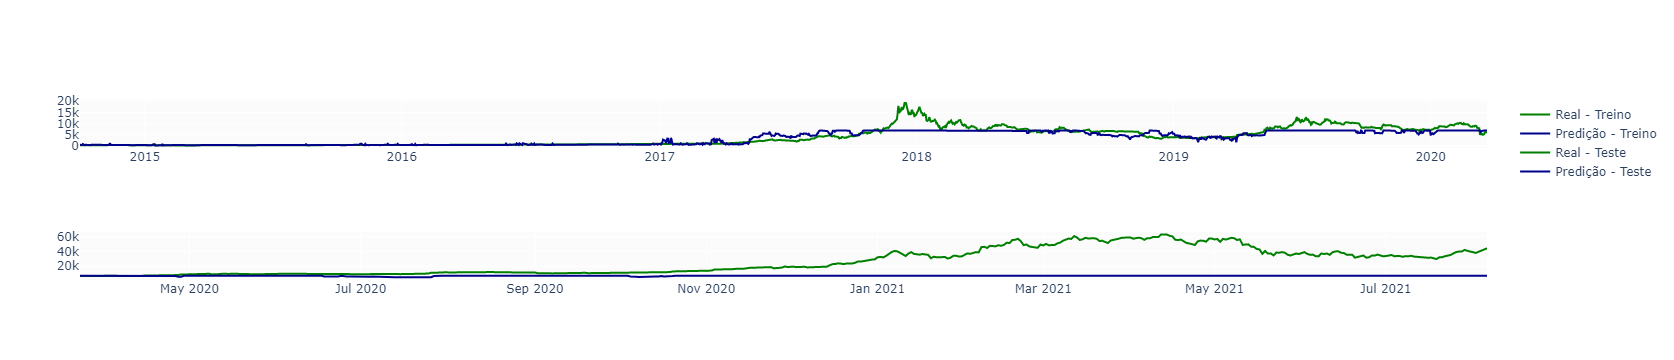



DataFrame consolidado de parâmetros e resultados tentados até aqui:


learning_rate  n_estimators  max_depth  min_child_weight  gamma  subsample  \
0           0.10         803.0        5.0               1.0    0.0        0.8   
1           0.10         401.0        7.0               5.0    0.6        1.0   
2           0.10         728.0        7.0               5.0    0.6        0.8   
3           0.10         728.0        7.0               5.0    0.6        0.8   
4           0.01         777.0        7.0               5.0    0.6        0.8   

   colsample_bytree  reg_alpha  reg_lambda  MAPE_train  MAPE_test  \
0               0.8     0.0000         1.0    0.005677   0.382134   
1               0.8     0.0000         1.0    0.004380   0.393929   
2               0.8     0.0001         1.0    0.000420   0.384805   
3               0.8     0.0001         1.0    0.000420   0.384805   
4               0.8     0.0001      2000.0    0.342161   0.583918   

     MSE_train      MSE_test    MAE_train      MAE_test    RMSE_train  \
0     6.874140  19683.201573     5.139906  13778.137542  4.725381e+01   
1     7.380973  19856.448987     4.781554  13989.589264  5.447877e+01   
2     0.525531  19624.206898     0.364898  13776.432786  2.761824e-01   
3     0.525531  19624.206898     0.364898  13776.432786  2.761824e-01   
4  1995.922712  26054.934957  1154.943934  19333.678345  3.983707e+06   

      RMSE_test  
0  3.874284e+08  
1  3.942786e+08  
2  3.851095e+08  
3  3.851095e+08  
4  6.788596e+08

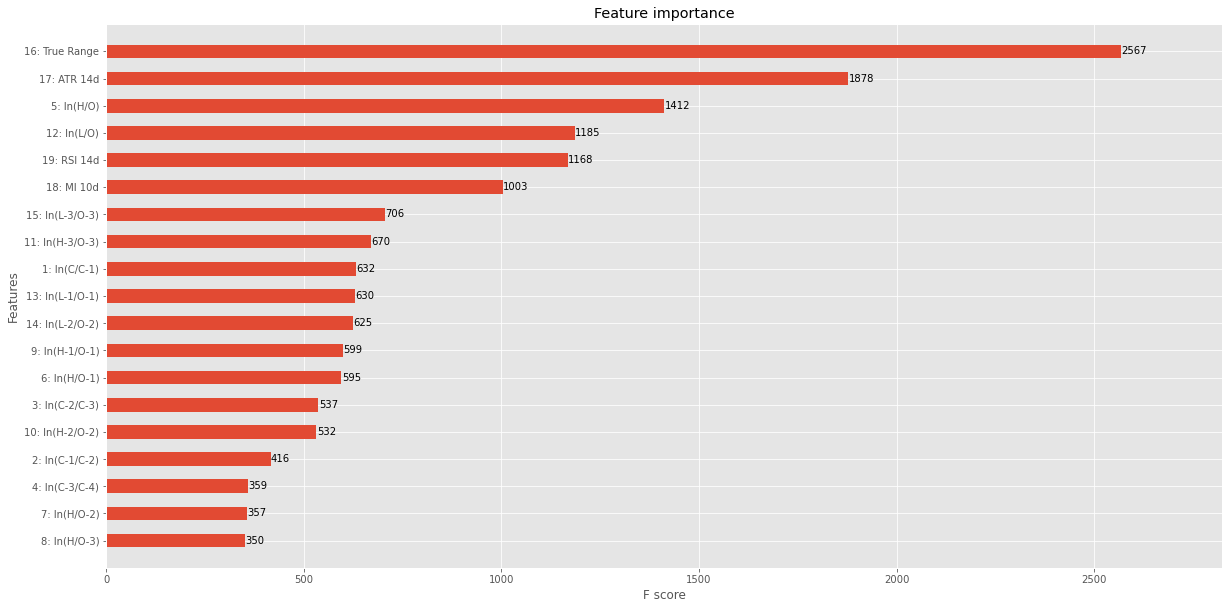

In [104]:
xgb4 = xgb.XGBRegressor(
         learning_rate =0.01,
         n_estimators=777,
         max_depth=7,
         min_child_weight=5,
         gamma=0.6,
         colsample_bytree=0.8,
         subsample = 0.8,
         reg_alpha = 0.0001,
         reg_lambda = 2000,
         objective= 'reg:squarederror',
         nthread=6,
         seed=248)

model_fit(estimator = xgb4, dtrain = list(dict_train.values())[0], dtest = list(dict_test.values())[0], features = list(dict_X_train.values())[0].columns, target = 'Close', dmodel = df_model, cv_folds=10, early_stopping_rounds=50)

Ficou péssimo... perdeu toda a sensibilidade. Algo errado aqui...

## Step 6: Reducing Learning Rate
Lastly, we should lower the learning rate and add more trees. Let's use the cv function of XGBoost to do the job again.

[0]	train-rmse:5629.72183+22.87435	test-rmse:5625.93228+207.72679
[1]	train-rmse:5616.71138+22.80117	test-rmse:5612.93271+207.47659
[2]	train-rmse:5603.76494+22.73932	test-rmse:5600.01226+207.19263
[3]	train-rmse:5590.89219+22.52117	test-rmse:5587.15591+207.06411
[4]	train-rmse:5578.05903+22.47233	test-rmse:5574.33047+206.78417
[5]	train-rmse:5565.43145+22.38998	test-rmse:5561.70024+206.52681
[6]	train-rmse:5552.67729+22.31162	test-rmse:5548.96294+206.26620
[7]	train-rmse:5539.98877+22.24957	test-rmse:5536.27847+206.00524
[8]	train-rmse:5527.39805+22.16347	test-rmse:5523.70205+205.75162
[9]	train-rmse:5514.78457+22.03036	test-rmse:5511.11104+205.55533
[10]	train-rmse:5502.20669+21.91879	test-rmse:5498.55356+205.33711
[11]	train-rmse:5489.61836+21.77654	test-rmse:5485.97866+205.15894
[12]	train-rmse:5477.13281+21.60697	test-rmse:5473.50537+205.01031
[13]	train-rmse:5464.87314+21.33075	test-rmse:5461.25078+204.98353
[14]	train-rmse:5452.47231+21.21525	test-rmse:5448.86987+204.77866
[15]	

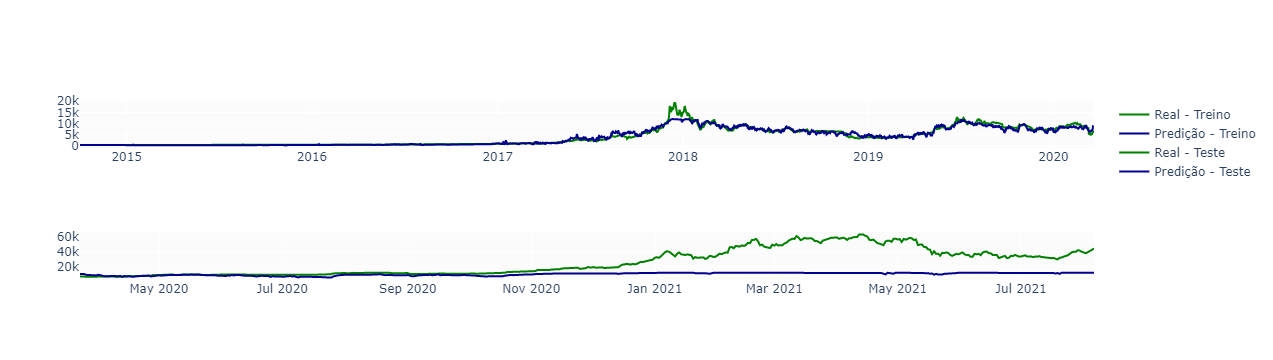



DataFrame consolidado de parâmetros e resultados tentados até aqui:


learning_rate  n_estimators  max_depth  min_child_weight  gamma  subsample  \
0           0.10         803.0        5.0               1.0    0.0        0.8   
1           0.10         401.0        7.0               5.0    0.6        1.0   
2           0.10         728.0        7.0               5.0    0.6        0.8   
3           0.10         728.0        7.0               5.0    0.6        0.8   
4           0.01         777.0        7.0               5.0    0.6        0.8   
5           0.01        5000.0        7.0               5.0    0.6        0.8   

   colsample_bytree  reg_alpha  reg_lambda  MAPE_train  MAPE_test  \
0               0.8     0.0000         1.0    0.005677   0.382134   
1               0.8     0.0000         1.0    0.004380   0.393929   
2               0.8     0.0001         1.0    0.000420   0.384805   
3               0.8     0.0001         1.0    0.000420   0.384805   
4               0.8     0.0001      2000.0    0.342161   0.583918   
5               0.8     0.0001      2000.0    0.142516   0.455847   

     MSE_train      MSE_test    MAE_train      MAE_test    RMSE_train  \
0     6.874140  19683.201573     5.139906  13778.137542  4.725381e+01   
1     7.380973  19856.448987     4.781554  13989.589264  5.447877e+01   
2     0.525531  19624.206898     0.364898  13776.432786  2.761824e-01   
3     0.525531  19624.206898     0.364898  13776.432786  2.761824e-01   
4  1995.922712  26054.934957  1154.943934  19333.678345  3.983707e+06   
5   910.344151  22735.857033   490.966966  16157.000536  8.287265e+05   

      RMSE_test  
0  3.874284e+08  
1  3.942786e+08  
2  3.851095e+08  
3  3.851095e+08  
4  6.788596e+08  
5  5.169192e+08

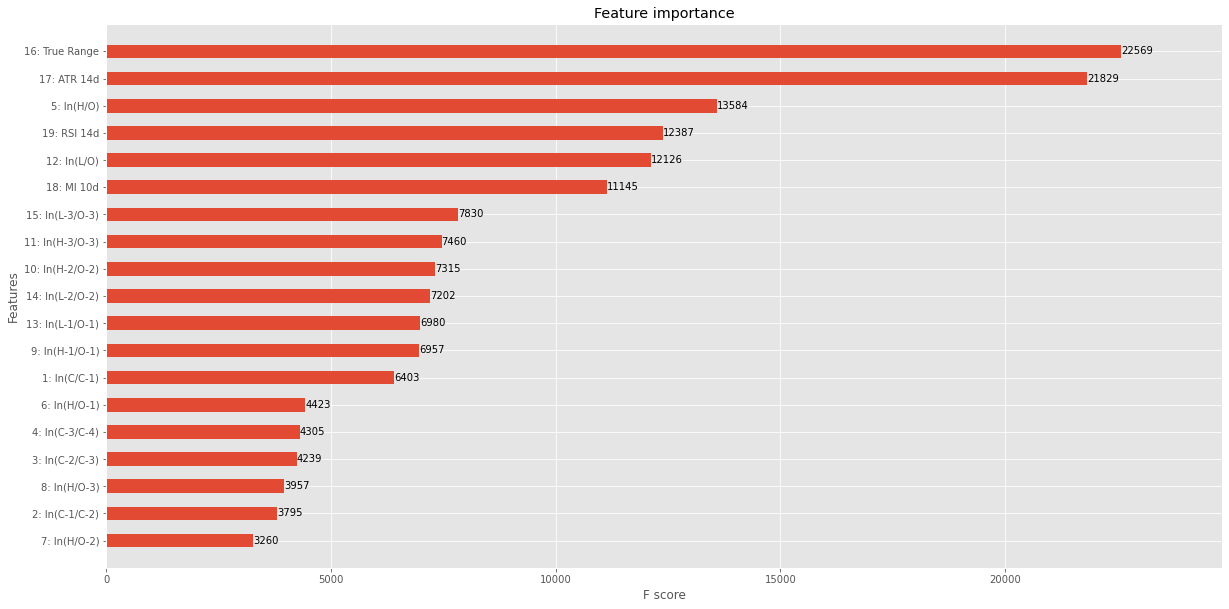

In [105]:
xgb5 = xgb.XGBRegressor(
         learning_rate =0.01,
         n_estimators=5000,
         max_depth=7,
         min_child_weight=5,
         gamma=0.6,
         colsample_bytree=0.8,
         subsample = 0.8,
         reg_alpha = 0.0001,
         reg_lambda = 2000,
         objective= 'reg:squarederror',
         nthread=6,
         seed=248)

model_fit(estimator = xgb5, dtrain = list(dict_train.values())[0], dtest = list(dict_test.values())[0], features = list(dict_X_train.values())[0].columns, target = 'Close', dmodel = df_model, cv_folds=10, early_stopping_rounds=50)

In [111]:
list(dict_test.values())[0]

Close  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  \
2020-03-23   6734.803711      0.095783       -0.059077       -0.002214   
2020-03-24   6681.062988      0.048445        0.095783       -0.059077   
2020-03-25   6716.440430     -0.008012        0.048445        0.095783   
2020-03-26   6469.798340      0.005281       -0.008012        0.048445   
2020-03-27   6242.193848     -0.037413        0.005281       -0.008012   
...                  ...           ...             ...             ...   
2021-08-02  38152.980469     -0.019525       -0.040478       -0.014533   
2021-08-03  39747.503906     -0.027122       -0.019525       -0.040478   
2021-08-04  40869.554688      0.040943       -0.027122       -0.019525   
2021-08-05  42816.500000      0.027838        0.040943       -0.027122   
2021-08-06  44555.800781      0.046538        0.027838        0.040943   

            4: ln(C-3/C-4)  5: ln(H/O)  6: ln(H/O-1)  7: ln(H/O-2)  \
2020-03-23        0.001224    0.099887      0.040922      0.037539   
2020-03-24       -0.002214    0.053300      0.152054      0.093090   
2020-03-25       -0.059077    0.022566      0.068428      0.167183   
2020-03-26        0.095783    0.008992     -0.000483      0.045380   
2020-03-27        0.048445    0.011019      0.017621      0.008146   
...                    ...         ...           ...           ...   
2021-08-02        0.054172    0.012746     -0.025445     -0.043028   
2021-08-03       -0.014533    0.014485     -0.003948     -0.042139   
2021-08-04       -0.040478    0.044502      0.019561      0.001128   
2021-08-05       -0.019525    0.039405      0.078693      0.053752   
2021-08-06       -0.027122    0.057203      0.085026      0.124313   

            8: ln(H/O-3)  9: ln(H-1/O-1)  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2020-03-23      0.039937        0.027764         0.027275         0.100208   
2020-03-24      0.089706        0.099887         0.027764         0.027275   
2020-03-25      0.108218        0.053300         0.099887         0.027764   
2020-03-26      0.144134        0.022566         0.053300         0.099887   
2020-03-27      0.054009        0.008992         0.022566         0.053300   
...                  ...             ...              ...              ...   
2021-08-02      0.009738        0.025735         0.000833         0.053696   
2021-08-03     -0.059722        0.012746         0.025735         0.000833   
2021-08-04     -0.037063        0.014485         0.012746         0.025735   
2021-08-05      0.035319        0.044502         0.014485         0.012746   
2021-08-06      0.099372        0.039405         0.044502         0.014485   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2020-03-23    -0.007984        -0.060279        -0.045100        -0.054066   
2020-03-24    -0.003981        -0.007984        -0.060279        -0.045100   
2020-03-25    -0.030402        -0.003981        -0.007984        -0.060279   
2020-03-26    -0.012695        -0.030402        -0.003981        -0.007984   
2020-03-27    -0.038331        -0.012695        -0.030402        -0.003981   
...                 ...              ...              ...              ...   
2021-08-02    -0.029522        -0.047413        -0.026061        -0.041578   
2021-08-03    -0.036291        -0.029522        -0.047413        -0.026061   
2021-08-04    -0.016469        -0.036291        -0.029522        -0.047413   
2021-08-05    -0.059251        -0.016469        -0.036291        -0.029522   
2021-08-06    -0.023113        -0.059251        -0.016469        -0.036291   

            16: True Range  17: ATR 14d   18: MI 10d  19: RSI 14d  
2020-03-23      658.930176   841.283308   852.607910    38.617370  
2020-03-24      377.956543   845.267194  1534.437500    41.517708  
2020-03-25      355.584961   848.665981  1288.748047    41.183699  
2020-03-26      144.500977   639.790179  1701.960449    71.432026  
2020-03-27      327.134766   539.504534  1244.168945    62.158202  
...    

# PESSIMO!

In [1]:
xgb6 = xgb.XGBRegressor(
         learning_rate =0.01,
         n_estimators=5000,
         max_depth=7,
         min_child_weight=5,
         gamma=0.6,
         colsample_bytree=0.8,
         subsample = 0.8,
         reg_alpha = 0.0001,
         reg_lambda = 1,
         objective= 'reg:squarederror',
         nthread=6,
         seed=248)

model_fit(estimator = xgb6, dtrain = list(dict_train.values())[0], dtest = list(dict_test.values())[0], features = list(dict_X_train.values())[0].columns, target = 'Close', dmodel = df_model, cv_folds=10, early_stopping_rounds=50)

NameError: name 'xgb' is not defined

In [ ]:
#Abner
#https://github.com/firefly-cpp/FireflyAlgorithm

# D é o tamanho do vagalume (# de hiperparametros)
# sol é um vagalume (uma combinação de hyperparametros)
def Fun(D, sol):

    xgb = (max_depth = sol[0], min_ = sol[1], ...) #cria o xgboost
    xfgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    erro = rmse(y_pred, y_test)        
    return erro

#fireflies = [ [ 0.1, 3, 0.01 ], [ 0.01, 2, 0.02 ]  ]

Algorithm = FireflyAlgorithm(3, 2, 10000, 0.5, 0.2, 1.0, -2.0, 2.0, Fun)
Best = Algorithm.Run()

print Best